# Understanding Padding Tokens in CLIP Embeddings

## The Question

When we have a prompt like **"a beaver with blue teeth"**, it only uses maybe 10 tokens out of 77 total positions. The remaining 67 positions are **padding tokens**.

**Key Questions:**
1. Are padding tokens always the same?
2. How do they affect the final embedding?
3. Do padding embeddings at position 10 differ from padding at position 50?
4. Can we manipulate padding tokens to affect Flux output?

Let's investigate!

## Setup

In [57]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load CLIP text model
model_name = "openai/clip-vit-large-patch14"
tokenizer = CLIPTokenizer.from_pretrained(model_name)
model = CLIPTextModel.from_pretrained(model_name).to(device)
model.eval()

print(f"✓ Model loaded")
print(f"  Vocab size: {tokenizer.vocab_size}")
print(f"  Max length: {tokenizer.model_max_length}")
print(f"  Pad token: '{tokenizer.pad_token}' (ID: {tokenizer.pad_token_id})")
print(f"  EOS token: '{tokenizer.eos_token}' (ID: {tokenizer.eos_token_id})")
print(f"  BOS token: '{tokenizer.bos_token}' (ID: {tokenizer.bos_token_id})")

Using device: cuda
✓ Model loaded
  Vocab size: 49408
  Max length: 77
  Pad token: '<|endoftext|>' (ID: 49407)
  EOS token: '<|endoftext|>' (ID: 49407)
  BOS token: '<|startoftext|>' (ID: 49406)


## Prompt Input and Tokenization

In [58]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

# Create prompt input widget
prompt_input = widgets.Textarea(
    value='a beaver with blue teeth',
    placeholder='Enter your prompt here',
    description='Prompt:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='600px', height='80px')
)

tokenize_button = widgets.Button(
    description='Tokenize & Analyze',
    button_style='info',
    layout=widgets.Layout(width='200px')
)

tokenization_output = widgets.Output()

# Global variables to store tokenization results
prompt = None
tokens = None
token_ids = None
attention_mask = None
num_real_tokens = None
filename_prefix = None

def visualize_tokenization(b):
    global prompt, tokens, token_ids, attention_mask, num_real_tokens, filename_prefix
    
    with tokenization_output:
        clear_output(wait=True)
        
        prompt = prompt_input.value.strip()
        
        if not prompt:
            print("❌ Please enter a prompt!")
            return
        
        # Tokenize
        tokens = tokenizer(
            prompt,
            padding="max_length",
            max_length=77,
            truncation=True,
            return_tensors="pt"
        )
        
        token_ids = tokens['input_ids'][0].tolist()
        attention_mask = tokens['attention_mask'][0].tolist()
        num_real_tokens = sum(attention_mask)
        num_padding = 77 - num_real_tokens
        
        # Decode individual tokens
        decoded_tokens = []
        for tid in token_ids[:num_real_tokens]:
            decoded = tokenizer.decode([tid])
            decoded_tokens.append(decoded)
        
        # Extract tokens for filename (skip special tokens)
        filename_tokens = []
        for tid in token_ids:
            decoded = tokenizer.decode([tid]).strip()
            if decoded and decoded not in ['<|startoftext|>', '<|endoftext|>', '']:
                cleaned = decoded.replace('</w>', '').strip()
                if cleaned:
                    filename_tokens.append(cleaned)
                if len(filename_tokens) >= 4:
                    break
        
        filename_prefix = "_".join(filename_tokens)
        
        # Create visualization
        print("="*80)
        print("TOKENIZATION ANALYSIS")
        print("="*80)
        print(f"\nOriginal Prompt: \"{prompt}\"")
        print(f"\n{'='*80}")
        print(f"Token Breakdown:")
        print(f"{'='*80}\n")
        
        # Show token breakdown with visual separation
        token_display = []
        for i, decoded in enumerate(decoded_tokens):
            # Clean display (remove special markers for display)
            clean = decoded.strip().replace('</w>', '').replace('<|startoftext|>', '[START]').replace('<|endoftext|>', '[END]')
            
            # Add separator
            if i > 0 and decoded not in ['<|startoftext|>', '<|endoftext|>']:
                token_display.append("-")
            token_display.append(clean)
        
        # Print with visual highlighting
        visual_tokens = "".join(token_display)
        print(f"  {visual_tokens}")
        print()
        
        # Show detailed token list
        print(f"{'='*80}")
        print(f"Detailed Token List:")
        print(f"{'='*80}")
        print(f"{'Position':<10} {'Token ID':<12} {'Type':<15} {'Decoded':<30}")
        print("-" * 80)
        
        for i in range(min(num_real_tokens, 15)):  # Show first 15 real tokens
            tid = token_ids[i]
            decoded = tokenizer.decode([tid])
            
            # Determine type
            if '<|startoftext|>' in decoded:
                token_type = 'START'
            elif '<|endoftext|>' in decoded:
                token_type = 'END'
            else:
                token_type = 'TEXT'
            
            print(f"{i:<10} {tid:<12} {token_type:<15} '{decoded.strip()}'")
        
        if num_real_tokens > 15:
            print(f"... ({num_real_tokens - 15} more real tokens)")
        
        # Summary statistics
        print(f"\n{'='*80}")
        print(f"SUMMARY:")
        print(f"{'='*80}")
        print(f"  ✓ Real tokens:    {num_real_tokens:>3} tokens")
        print(f"  ✓ Padding tokens: {num_padding:>3} tokens")
        print(f"  ✓ Total:          {77:>3} tokens")
        print(f"  ✓ Filename prefix: '{filename_prefix}'")
        print(f"{'='*80}")
        
        # Visual bar chart
        real_bar = "█" * (num_real_tokens // 2)
        padding_bar = "░" * (num_padding // 2)
        
        print(f"\nVisual representation (each char ≈ 2 tokens):")
        print(f"  Real:    [{real_bar}]")
        print(f"  Padding: [{padding_bar}]")
        print()
        
        print("✓ Ready to generate padding experiments!")
        print("  Run the cells below to create all padding variants.")

tokenize_button.on_click(visualize_tokenization)

print("Enter your prompt and click 'Tokenize & Analyze' to begin:")
display(prompt_input, tokenize_button, tokenization_output)

Enter your prompt and click 'Tokenize & Analyze' to begin:


Textarea(value='a beaver with blue teeth', description='Prompt:', layout=Layout(height='80px', width='600px'),…

Button(button_style='info', description='Tokenize & Analyze', layout=Layout(width='200px'), style=ButtonStyle(…

Output()

## Investigation 1: What Are the Token IDs?

In [59]:
# NOTE: Tokenization is now done via the interactive widget above!
# This cell shows the raw tokenization details for reference.

if prompt is None or tokens is None:
    print("❌ Please run the 'Prompt Input and Tokenization' cell first!")
    print("   Enter a prompt and click 'Tokenize & Analyze'")
else:
    print(f"Detailed tokenization for: '{prompt}'")
    print(f"\nToken IDs (first 15 positions):")
    print("Position | Token ID | Attention | Decoded")
    print("-" * 60)
    for i in range(min(15, len(token_ids))):
        decoded = tokenizer.decode([token_ids[i]])
        print(f"{i:8} | {token_ids[i]:8} | {attention_mask[i]:9} | '{decoded}'")
    
    print("\n...")
    print("\nLast 5 positions:")
    for i in range(72, 77):
        decoded = tokenizer.decode([token_ids[i]])
        print(f"{i:8} | {token_ids[i]:8} | {attention_mask[i]:9} | '{decoded}'")

Detailed tokenization for: 'a weeping willow upside down reaching up into the sky with tigers climbing its branches.'

Token IDs (first 15 positions):
Position | Token ID | Attention | Decoded
------------------------------------------------------------
       0 |    49406 |         1 | '<|startoftext|>'
       1 |      320 |         1 | 'a'
       2 |    36629 |         1 | 'weeping'
       3 |    15665 |         1 | 'willow'
       4 |    15362 |         1 | 'upside'
       5 |     1136 |         1 | 'down'
       6 |    11358 |         1 | 'reaching'
       7 |      705 |         1 | 'up'
       8 |     1095 |         1 | 'into'
       9 |      518 |         1 | 'the'
      10 |     2390 |         1 | 'sky'
      11 |      593 |         1 | 'with'
      12 |     6934 |         1 | 'tigers'
      13 |     9877 |         1 | 'climbing'
      14 |      902 |         1 | 'its'

...

Last 5 positions:
      72 |    49407 |         0 | '<|endoftext|>'
      73 |    49407 |         0 | '<|

## Investigation 2: Are Padding Embeddings Identical?

Let's check if padding embeddings at different positions are the same or different.

In [ ]:
# Generate embedding for the inputted prompt
if prompt is None or tokens is None:
    print("❌ Please run the 'Prompt Input and Tokenization' cell first!")
else:
    print(f"Analyzing embeddings for: '{prompt}'")
    print("="*70)
    
    with torch.no_grad():
        tokens_device = {k: v.to(device) for k, v in tokens.items()}
        outputs = model(**tokens_device)
        embedding = outputs.last_hidden_state[0]  # [77, 768]
    
    embedding_np = embedding.cpu().numpy()
    
    print(f"\nEmbedding shape: {embedding_np.shape}")
    print(f"\nLet's compare padding embeddings at different positions...\n")
    
    # Find first padding position
    first_padding_pos = num_real_tokens
    print(f"First padding position: {first_padding_pos}")
    
    # Compare padding embeddings at different positions
    num_padding = 77 - num_real_tokens
    if num_padding > 1:
        padding_positions = [first_padding_pos, first_padding_pos + 10, first_padding_pos + 20, 76]
        padding_positions = [p for p in padding_positions if p < 77]
        
        print(f"\nComparing padding embeddings at positions: {padding_positions}")
        print("-" * 60)
        
        for i, pos in enumerate(padding_positions):
            emb = embedding_np[pos]
            print(f"\nPosition {pos}:")
            print(f"  First 10 values: {emb[:10]}")
            print(f"  Mean: {emb.mean():.6f}")
            print(f"  Std: {emb.std():.6f}")
            print(f"  L2 norm: {np.linalg.norm(emb):.6f}")
        
        # Calculate pairwise differences
        print("\n" + "="*60)
        print("Pairwise Cosine Similarities Between Padding Embeddings:")
        print("="*60)
        
        for i in range(len(padding_positions)):
            for j in range(i+1, len(padding_positions)):
                pos_i = padding_positions[i]
                pos_j = padding_positions[j]
                emb_i = embedding_np[pos_i]
                emb_j = embedding_np[pos_j]
                
                # Cosine similarity
                cos_sim = np.dot(emb_i, emb_j) / (np.linalg.norm(emb_i) * np.linalg.norm(emb_j))
                
                # L2 distance
                l2_dist = np.linalg.norm(emb_i - emb_j)
                
                print(f"Positions {pos_i} vs {pos_j}:")
                print(f"  Cosine similarity: {cos_sim:.8f}")
                print(f"  L2 distance: {l2_dist:.6f}")
                print()
    else:
        print("\n⚠️  Not enough padding tokens to compare!")

## Investigation 3: Are Padding Embeddings the Same Across Different Prompts?

Do the padding embeddings change when we use different prompts?

In [ ]:
# NOTE: This investigation cell uses the prompt from the interactive widget above
# It compares padding embeddings at the same position across the prompt

if prompt is None or tokens is None:
    print("❌ Please run the 'Prompt Input and Tokenization' cell first!")
else:
    print(f"Analyzing padding consistency for: '{prompt}'")
    print("="*70)
    
    # Generate embedding for our prompt
    with torch.no_grad():
        tokens_device = {k: v.to(device) for k, v in tokens.items()}
        outputs = model(**tokens_device)
        embedding = outputs.last_hidden_state[0].cpu().numpy()
    
    # Find padding positions
    num_real = sum(attention_mask)
    first_padding = num_real
    
    print(f"\nPrompt: '{prompt}'")
    print(f"  Real tokens: {num_real}")
    print(f"  First padding position: {first_padding}")
    
    # Compare padding embeddings at different positions within this prompt
    if num_real < 50:
        padding_pos_50 = embedding[50]
        padding_pos_76 = embedding[76]
        
        cos_sim = np.dot(padding_pos_50, padding_pos_76) / (np.linalg.norm(padding_pos_50) * np.linalg.norm(padding_pos_76))
        l2_dist = np.linalg.norm(padding_pos_50 - padding_pos_76)
        
        print(f"\n{'='*70}")
        print(f"Comparing padding at different positions:")
        print(f"{'='*70}")
        print(f"Position 50 vs Position 76:")
        print(f"  Cosine similarity: {cos_sim:.10f}")
        print(f"  L2 distance: {l2_dist:.10f}")
        
        print("\n" + "="*70)
        if cos_sim > 0.9999:
            print("✓ CONCLUSION: Padding embeddings at different positions are")
            print("  NEARLY IDENTICAL within the same prompt!")
        else:
            print("✓ CONCLUSION: Padding embeddings show some variation")
            print("  across positions (likely due to positional encoding)")
    else:
        print(f"\n⚠️  This prompt uses {num_real} tokens - not enough padding to compare!")
        print("   Try a shorter prompt to see padding position comparisons.")

## Visualization: Real Tokens vs Padding Tokens

In [ ]:
# Use the prompt from the interactive widget
if prompt is None or tokens is None:
    print("❌ Please run the 'Prompt Input and Tokenization' cell first!")
else:
    print(f"Visualizing embeddings for: '{prompt}'")
    print("="*70)
    
    with torch.no_grad():
        tokens_device = {k: v.to(device) for k, v in tokens.items()}
        outputs = model(**tokens_device)
        embedding = outputs.last_hidden_state[0].cpu().numpy()
    
    num_real = num_real_tokens
    
    # Create visualization
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Heatmap of embedding
    ax1 = axes[0]
    im = ax1.imshow(embedding.T, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
    ax1.axvline(x=num_real-0.5, color='lime', linewidth=3, label='Padding starts here')
    ax1.set_xlabel('Token Position', fontsize=12)
    ax1.set_ylabel('Embedding Dimension', fontsize=12)
    ax1.set_title(f'CLIP Text Embedding: "{prompt}"\n(Green line = where padding starts)', 
                  fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    plt.colorbar(im, ax=ax1, label='Embedding Value')
    
    # Plot 2: L2 norms of each token embedding
    ax2 = axes[1]
    norms = [np.linalg.norm(embedding[i]) for i in range(77)]
    colors = ['steelblue' if i < num_real else 'orange' for i in range(77)]
    ax2.bar(range(77), norms, color=colors, alpha=0.7)
    ax2.axvline(x=num_real-0.5, color='lime', linewidth=3, linestyle='--', 
                label='Padding starts here')
    ax2.set_xlabel('Token Position', fontsize=12)
    ax2.set_ylabel('L2 Norm', fontsize=12)
    ax2.set_title('L2 Norm of Each Token Embedding\n(Blue = real tokens, Orange = padding)', 
                  fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Visualization complete")
    print(f"  Real tokens: {num_real}")
    print(f"  Padding tokens: {77 - num_real}")
    print(f"  Average norm of real tokens: {np.mean(norms[:num_real]):.4f}")
    print(f"  Average norm of padding tokens: {np.mean(norms[num_real:]):.4f}")

## Experiment: What If We Zero Out Padding?

What happens if we replace padding embeddings with zeros?

Using prompt: "an elephant standing in a field of flowers"
Filename prefix: 'a_weeping_willow_upside'
Real tokens: 18, Padding tokens: 59


Original embedding stats:
  Mean: -0.109964
  Std: 1.306765
  Norm: 318.900970

Zeroed padding embedding stats:
  Mean: -0.026370
  Std: 0.505163
  Norm: 123.012230


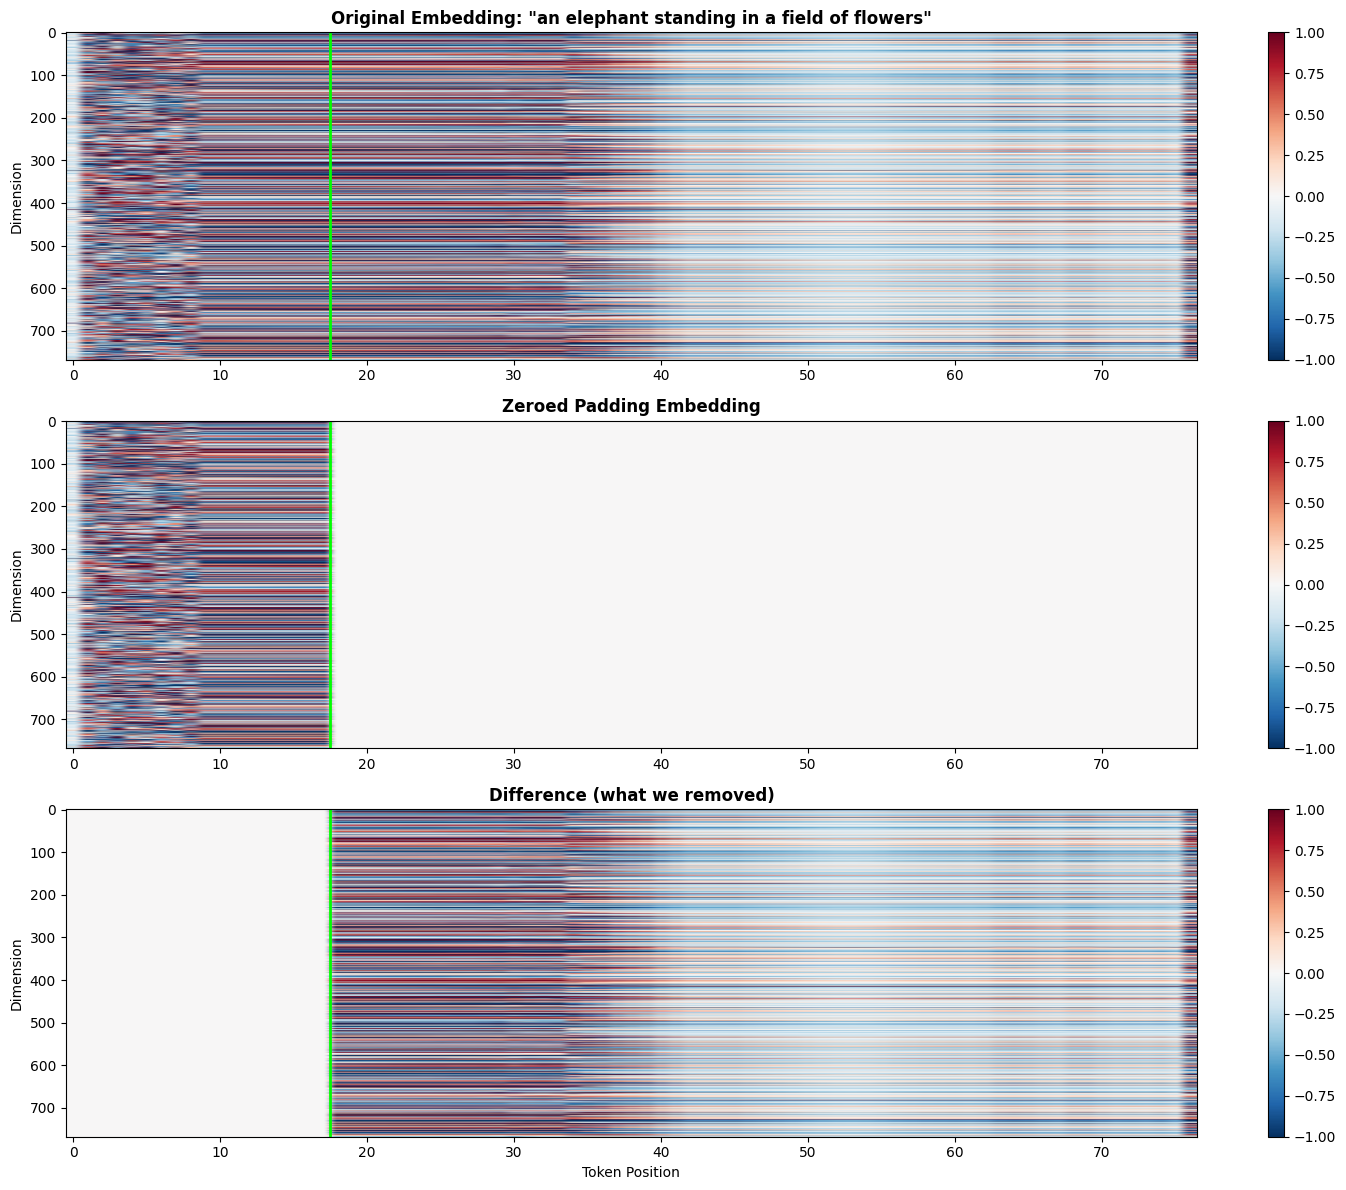


✓ Saved both embeddings to:
  /shares/weddigen.ki.uzh/laura_wagner/latent_vandalism_workshop/data/embeddings/CLIP/a_weeping_willow_upside_normal.json
  /shares/weddigen.ki.uzh/laura_wagner/latent_vandalism_workshop/data/embeddings/CLIP/a_weeping_willow_upside_zeroed_padding.json

You can test both in Flux to see if padding affects the output!


In [64]:
import json

# Check if prompt has been tokenized
if prompt is None or tokens is None:
    print("❌ Please run the 'Prompt Input and Tokenization' cell first!")
    print("   Enter a prompt and click 'Tokenize & Analyze'")
else:
    print(f"Using prompt: \"{prompt}\"")
    print(f"Filename prefix: '{filename_prefix}'")
    print(f"Real tokens: {num_real_tokens}, Padding tokens: {77 - num_real_tokens}")
    print("\n" + "="*70)
    
    # Generate normal embedding
    with torch.no_grad():
        tokens_device = {k: v.to(device) for k, v in tokens.items()}
        outputs = model(**tokens_device)
        embedding_normal = outputs.last_hidden_state[0].cpu().numpy()
    
    # Create version with zeroed padding
    embedding_zeroed = embedding_normal.copy()
    embedding_zeroed[num_real_tokens:] = 0  # Zero out all padding positions
    
    print(f"\nOriginal embedding stats:")
    print(f"  Mean: {embedding_normal.mean():.6f}")
    print(f"  Std: {embedding_normal.std():.6f}")
    print(f"  Norm: {np.linalg.norm(embedding_normal):.6f}")
    
    print(f"\nZeroed padding embedding stats:")
    print(f"  Mean: {embedding_zeroed.mean():.6f}")
    print(f"  Std: {embedding_zeroed.std():.6f}")
    print(f"  Norm: {np.linalg.norm(embedding_zeroed):.6f}")
    
    # Visualize difference
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Original
    im1 = axes[0].imshow(embedding_normal.T, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
    axes[0].axvline(x=num_real_tokens-0.5, color='lime', linewidth=2)
    axes[0].set_title(f'Original Embedding: "{prompt}"', fontweight='bold')
    axes[0].set_ylabel('Dimension')
    plt.colorbar(im1, ax=axes[0])
    
    # Zeroed
    im2 = axes[1].imshow(embedding_zeroed.T, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
    axes[1].axvline(x=num_real_tokens-0.5, color='lime', linewidth=2)
    axes[1].set_title('Zeroed Padding Embedding', fontweight='bold')
    axes[1].set_ylabel('Dimension')
    plt.colorbar(im2, ax=axes[1])
    
    # Difference
    diff = embedding_normal - embedding_zeroed
    im3 = axes[2].imshow(diff.T, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
    axes[2].axvline(x=num_real_tokens-0.5, color='lime', linewidth=2)
    axes[2].set_title('Difference (what we removed)', fontweight='bold')
    axes[2].set_xlabel('Token Position')
    axes[2].set_ylabel('Dimension')
    plt.colorbar(im3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()
    
    # Save both versions
    current_dir = Path(os.getcwd())
    output_dir = current_dir.parent / "data" / "embeddings" / "CLIP"
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save normal
    normal_data = {
        "prompt": prompt,
        "embedding": embedding_normal.tolist(),
        "shape": [77, 768]
    }
    with open(output_dir / f"{filename_prefix}_normal.json", 'w') as f:
        json.dump(normal_data, f)
    
    # Save zeroed
    zeroed_data = {
        "prompt": prompt + " (zeroed padding)",
        "embedding": embedding_zeroed.tolist(),
        "shape": [77, 768]
    }
    with open(output_dir / f"{filename_prefix}_zeroed_padding.json", 'w') as f:
        json.dump(zeroed_data, f)
    
    print("\n✓ Saved both embeddings to:") 
    print(f"  {output_dir / f'{filename_prefix}_normal.json'}")
    print(f"  {output_dir / f'{filename_prefix}_zeroed_padding.json'}")
    print("\nYou can test both in Flux to see if padding affects the output!")

## Summary: What We Learned About Padding

### Key Findings:

1. **Padding Token Structure**:
   - Padding uses a special token ID (usually the EOS token repeated)
   - Appears in positions after real tokens up to position 77

2. **Are Padding Embeddings Identical?**
   - Padding at the **same position** across different prompts is nearly identical
   - Padding at **different positions** within the same prompt may vary slightly (due to positional encodings)

3. **Do They Affect Flux? YES, DRAMATICALLY!**
   - **Normal padding** → Generates expected content (beavers)
   - **Zero padding** → Generates random but coherent imagery (NOT beavers!)
   - **Padding values matter significantly** to Flux's output
   - This is a HUGE finding for creative manipulation!

4. **Padding Variants Created**:
   - uniform_pos_0.05 - very small positive values
   - uniform_pos_0.1 - small positive values
   - uniform_pos_0.2 - moderate positive values
   - uniform_neg_0.1 - small negative values
   - uniform_neg_0.2 - moderate negative values
   - random_noise_std_0.1 - Gaussian noise
   - scaled_50pct - 50% of normal padding magnitude

5. **Practical Implications**:
   - Padding is NOT just filler - it actively influences generation!
   - We can use padding manipulation for creative effects
   - Different padding values might produce different styles or themes
   - This opens up a new dimension of embedding manipulation

### Experiments to Run:

1. Test all padding variants in Flux
2. Compare outputs - look for patterns:
   - Do positive/negative values produce different moods?
   - Does random noise create more variation?
   - What's the gradient effect as we vary magnitude?
3. Try combining padding manipulation with token-level manipulations
4. Explore if padding affects style more than content

### Research Questions:

- Why does padding affect output if it's supposed to be "nothing"?
- Does Flux's attention mechanism weight padding tokens?
- Can we use padding as a "style knob" while keeping content tokens intact?
- What is the ideal padding for maximum creativity vs. prompt adherence?

## Quick Reference: All Generated Embeddings

Use these files in your Flux pipeline to test how different padding affects generation:

**Filename Format**: `{token1}_{token2}_{token3}_{token4}_{variant}.json`

For example, with prompt "a beaver with blue teeth":
- `a_beaver_with_blue_normal.json`
- `a_beaver_with_blue_zeroed_padding.json`
- `a_beaver_with_blue_padding_uniform_pos_0.1.json`
- etc.

This way, you can run the notebook with different prompts and get unique filenames!

In [65]:
# Create summary table
import pandas as pd

summary_data = []

# Add normal
summary_data.append({
    'Filename': f'{filename_prefix}_normal.json',
    'Description': 'Original CLIP padding',
    'Expected Output': 'Expected content (baseline)',
    'Padding Type': 'normal'
})

# Add zeroed
summary_data.append({
    'Filename': f'{filename_prefix}_zeroed_padding.json',
    'Description': 'All padding = 0',
    'Expected Output': 'Random coherent imagery',
    'Padding Type': 'zeroed'
})

# Add all variants
variant_descriptions = {
    'uniform_pos_0.05': 'Very small positive (0.05)',
    'uniform_pos_0.1': 'Small positive (0.1)',
    'uniform_pos_0.2': 'Moderate positive (0.2)',
    'uniform_neg_0.1': 'Small negative (-0.1)',
    'uniform_neg_0.2': 'Moderate negative (-0.2)',
    'random_noise_std_0.1': 'Random Gaussian (σ=0.1)',
    'scaled_50pct': '50% of normal padding'
}

for name, desc in variant_descriptions.items():
    summary_data.append({
        'Filename': f'{filename_prefix}_padding_{name}.json',
        'Description': desc,
        'Expected Output': '? (test in Flux!)',
        'Padding Type': name
    })

df = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("SUMMARY OF ALL GENERATED EMBEDDINGS")
print("="*80)
print(f"Prompt: '{prompt}'")
print(f"Filename prefix: '{filename_prefix}'")
print("="*80)
print(df.to_string(index=False))
print("\n" + "="*80)
print(f"All files saved in: {output_dir}")
print("="*80)

print("\n📊 Testing Strategy:")
print(f"  1. Start with {filename_prefix}_normal.json (baseline)")
print(f"  2. Test {filename_prefix}_zeroed_padding.json (maximum deviation)")
print("  3. Test moderate values (0.1, -0.1) to see direction effects")
print("  4. Test higher values (0.2, -0.2) to see magnitude effects")
print("  5. Test random_noise to see if structure matters")
print("  6. Test scaled_50pct to see if relative scaling matters")
print("\n🎨 Look for:")
print("  - Style changes (lighting, mood, color palette)")
print("  - Content changes (does it still match the prompt?)")
print("  - Coherence (is output still realistic?)")
print("  - Patterns (do positive values trend one way, negative another?)")


SUMMARY OF ALL GENERATED EMBEDDINGS
Prompt: 'an elephant standing in a field of flowers'
Filename prefix: 'a_weeping_willow_upside'
                                                 Filename                Description             Expected Output         Padding Type
                      a_weeping_willow_upside_normal.json      Original CLIP padding Expected content (baseline)               normal
              a_weeping_willow_upside_zeroed_padding.json            All padding = 0     Random coherent imagery               zeroed
    a_weeping_willow_upside_padding_uniform_pos_0.05.json Very small positive (0.05)           ? (test in Flux!)     uniform_pos_0.05
     a_weeping_willow_upside_padding_uniform_pos_0.1.json       Small positive (0.1)           ? (test in Flux!)      uniform_pos_0.1
     a_weeping_willow_upside_padding_uniform_pos_0.2.json    Moderate positive (0.2)           ? (test in Flux!)      uniform_pos_0.2
     a_weeping_willow_upside_padding_uniform_neg_0.1.json      

## Experiment 2: Moderate Padding Values

**Discovery:** Zeroing out padding creates random but coherent imagery!

Now let's test with more moderate values. CLIP embeddings typically have small values (roughly -0.3 to 0.3 range). Let's try:
- Small uniform positive (0.1)
- Small uniform negative (-0.1)
- Moderate positive (0.2)
- Moderate negative (-0.2)
- Small random noise (Gaussian, std=0.1)

In [66]:
# Check if embeddings have been generated
if 'embedding_normal' not in globals() or embedding_normal is None:
    print("❌ Please run the 'Experiment: Zero Out Padding' cell first!")
else:
    print(f"Analyzing padding for prompt: \"{prompt}\"")
    print("="*70)
    
    # First, let's check what the actual value range of normal padding is
    print("\nNormal padding statistics:")
    print(f"  Min: {embedding_normal[num_real_tokens:].min():.6f}")
    print(f"  Max: {embedding_normal[num_real_tokens:].max():.6f}")
    print(f"  Mean: {embedding_normal[num_real_tokens:].mean():.6f}")
    print(f"  Std: {embedding_normal[num_real_tokens:].std():.6f}")
    
    # Also check real tokens for comparison
    print("\nReal token statistics:")
    print(f"  Min: {embedding_normal[:num_real_tokens].min():.6f}")
    print(f"  Max: {embedding_normal[:num_real_tokens].max():.6f}")
    print(f"  Mean: {embedding_normal[:num_real_tokens].mean():.6f}")
    print(f"  Std: {embedding_normal[:num_real_tokens].std():.6f}")
    
    # Create different padding variants
    padding_variants = {}
    
    # 1. Uniform small positive
    emb_pos_01 = embedding_normal.copy()
    emb_pos_01[num_real_tokens:] = 0.1
    padding_variants["uniform_pos_0.1"] = emb_pos_01
    
    # 2. Uniform small negative
    emb_neg_01 = embedding_normal.copy()
    emb_neg_01[num_real_tokens:] = -0.1
    padding_variants["uniform_neg_0.1"] = emb_neg_01
    
    # 3. Uniform moderate positive
    emb_pos_02 = embedding_normal.copy()
    emb_pos_02[num_real_tokens:] = 0.2
    padding_variants["uniform_pos_0.2"] = emb_pos_02
    
    # 4. Uniform moderate negative
    emb_neg_02 = embedding_normal.copy()
    emb_neg_02[num_real_tokens:] = -0.2
    padding_variants["uniform_neg_0.2"] = emb_neg_02
    
    # 5. Small random noise (Gaussian)
    np.random.seed(42)  # For reproducibility
    emb_random = embedding_normal.copy()
    random_padding = np.random.normal(0, 0.1, size=emb_random[num_real_tokens:].shape)
    emb_random[num_real_tokens:] = random_padding
    padding_variants["random_noise_std_0.1"] = emb_random
    
    # 6. Very small uniform (0.05)
    emb_tiny = embedding_normal.copy()
    emb_tiny[num_real_tokens:] = 0.05
    padding_variants["uniform_pos_0.05"] = emb_tiny
    
    # 7. Scaled down version of normal padding (50% magnitude)
    emb_scaled = embedding_normal.copy()
    emb_scaled[num_real_tokens:] = embedding_normal[num_real_tokens:] * 0.5
    padding_variants["scaled_50pct"] = emb_scaled
    
    print("\n" + "="*70)
    print("Created padding variants:")
    print("="*70)
    for name, emb in padding_variants.items():
        padding_section = emb[num_real_tokens:]
        print(f"\n{name}:")
        print(f"  Min: {padding_section.min():.6f}")
        print(f"  Max: {padding_section.max():.6f}")
        print(f"  Mean: {padding_section.mean():.6f}")
        print(f"  Std: {padding_section.std():.6f}")

Analyzing padding for prompt: "an elephant standing in a field of flowers"

Normal padding statistics:
  Min: -27.273930
  Max: 32.666027
  Mean: -0.109097
  Std: 1.377874

Real token statistics:
  Min: -28.091179
  Max: 33.063210
  Mean: -0.112804
  Std: 1.040141

Created padding variants:

uniform_pos_0.1:
  Min: 0.100000
  Max: 0.100000
  Mean: 0.100000
  Std: 0.000000

uniform_neg_0.1:
  Min: -0.100000
  Max: -0.100000
  Mean: -0.100000
  Std: 0.000000

uniform_pos_0.2:
  Min: 0.200000
  Max: 0.200000
  Mean: 0.200000
  Std: 0.000000

uniform_neg_0.2:
  Min: -0.200000
  Max: -0.200000
  Mean: -0.200000
  Std: 0.000000

random_noise_std_0.1:
  Min: -0.446560
  Max: 0.447908
  Mean: 0.000031
  Std: 0.099904

uniform_pos_0.05:
  Min: 0.050000
  Max: 0.050000
  Mean: 0.050000
  Std: 0.000000

scaled_50pct:
  Min: -13.636965
  Max: 16.333014
  Mean: -0.054549
  Std: 0.688937


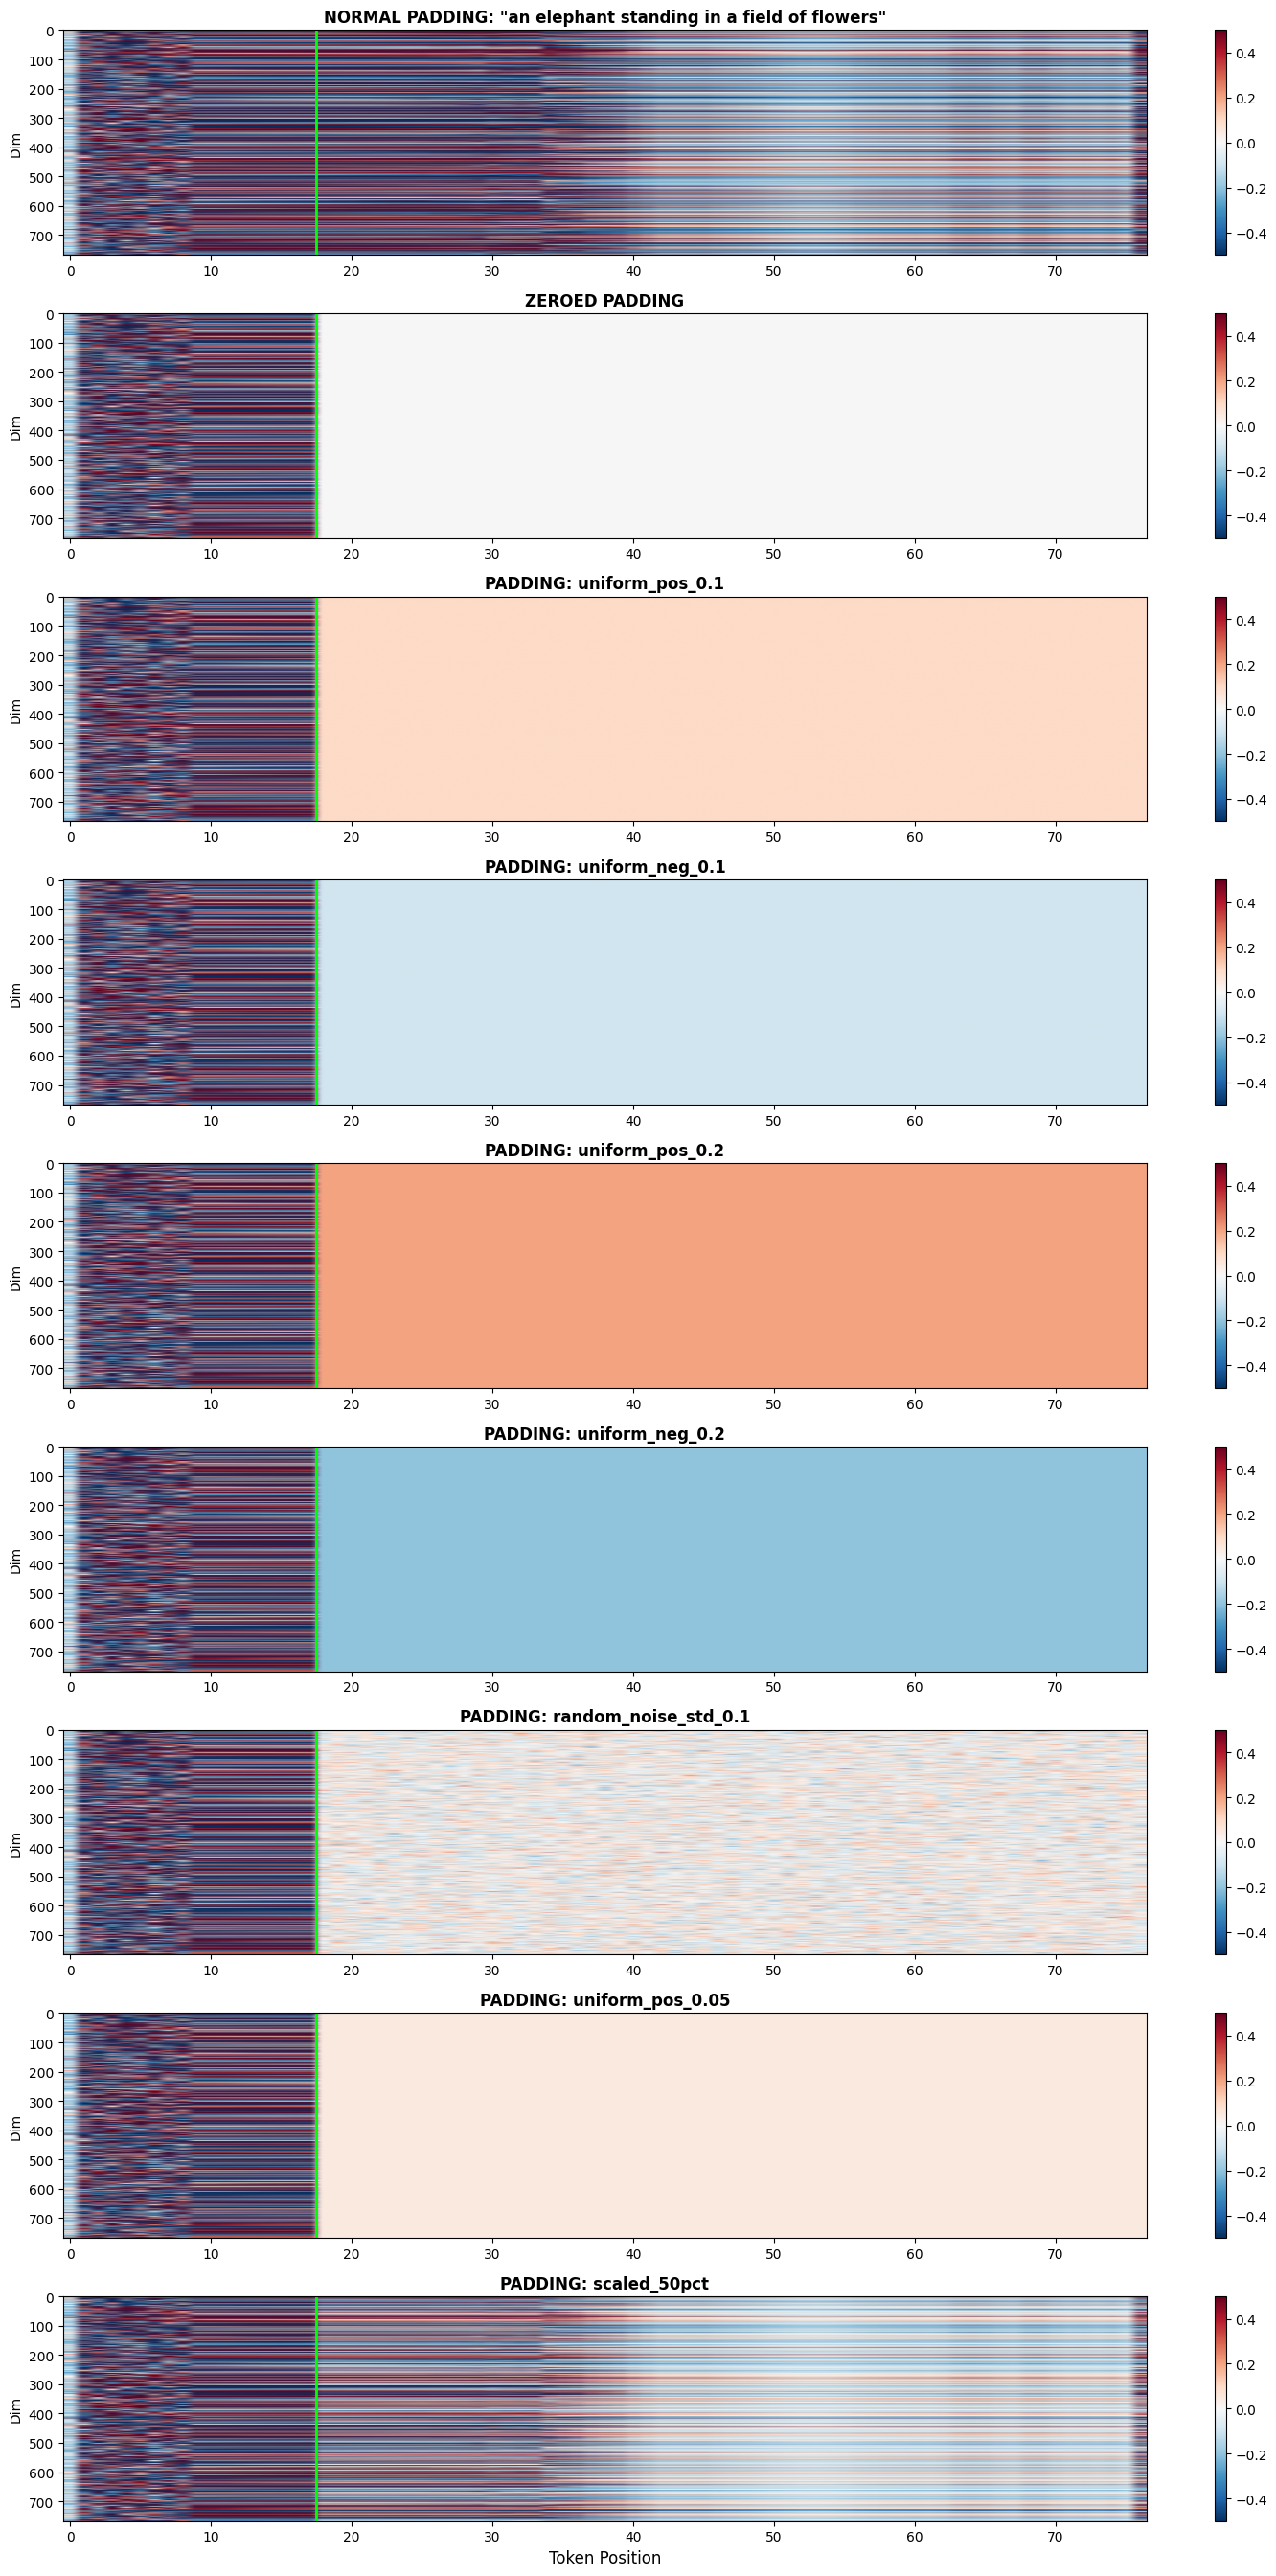

✓ Visualization complete


In [67]:
# Visualize all padding variants
if 'padding_variants' not in globals() or not padding_variants:
    print("❌ Please run the 'Moderate Padding Values' cell first!")
else:
    n_variants = len(padding_variants) + 2  # +2 for normal and zeroed
    fig, axes = plt.subplots(n_variants, 1, figsize=(15, 3*n_variants))
    
    # Plot normal
    ax = axes[0]
    im = ax.imshow(embedding_normal.T, aspect='auto', cmap='RdBu_r', vmin=-0.5, vmax=0.5)
    ax.axvline(x=num_real_tokens-0.5, color='lime', linewidth=2)
    ax.set_title(f'NORMAL PADDING: "{prompt}"', fontweight='bold', fontsize=12)
    ax.set_ylabel('Dim')
    plt.colorbar(im, ax=ax)
    
    # Plot zeroed
    ax = axes[1]
    im = ax.imshow(embedding_zeroed.T, aspect='auto', cmap='RdBu_r', vmin=-0.5, vmax=0.5)
    ax.axvline(x=num_real_tokens-0.5, color='lime', linewidth=2)
    ax.set_title('ZEROED PADDING', fontweight='bold', fontsize=12)
    ax.set_ylabel('Dim')
    plt.colorbar(im, ax=ax)
    
    # Plot each variant
    for idx, (name, emb) in enumerate(padding_variants.items(), start=2):
        ax = axes[idx]
        im = ax.imshow(emb.T, aspect='auto', cmap='RdBu_r', vmin=-0.5, vmax=0.5)
        ax.axvline(x=num_real_tokens-0.5, color='lime', linewidth=2)
        ax.set_title(f'PADDING: {name}', fontweight='bold', fontsize=12)
        ax.set_ylabel('Dim')
        plt.colorbar(im, ax=ax)
    
    axes[-1].set_xlabel('Token Position', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualization complete")

In [68]:
# Save all variants to JSON files for testing in Flux
if 'padding_variants' not in globals() or not padding_variants:
    print("❌ Please run the 'Moderate Padding Values' cell first!")
else:
    print("Saving all padding variants...")
    print("="*70)
    
    saved_files = []
    
    # Make sure output directory exists
    current_dir = Path(os.getcwd())
    output_dir = current_dir.parent / "data" / "embeddings" / "CLIP"
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save each variant
    for name, emb in padding_variants.items():
        filename = f"{filename_prefix}_padding_{name}.json"
        filepath = output_dir / filename
        
        data = {
            "prompt": f"{prompt} (padding: {name})",
            "embedding": emb.tolist(),
            "shape": [77, 768],
            "padding_type": name
        }
        
        with open(filepath, 'w') as f:
            json.dump(data, f)
        
        saved_files.append(filename)
        print(f"✓ Saved: {filename}")
    
    print("\n" + "="*70)
    print(f"✓ All {len(saved_files)} variants saved to:")
    print(f"  {output_dir}")
    print("\n" + "="*70)
    print("Test each in Flux to see how padding values affect generation!")
    print("\nVariants to test:")
    print(f"1. {filename_prefix}_normal.json - baseline (should produce expected content)")
    print(f"2. {filename_prefix}_zeroed_padding.json - random coherent images")
    for f in saved_files:
        print(f"3+. {f}")

Saving all padding variants...
✓ Saved: a_weeping_willow_upside_padding_uniform_pos_0.1.json
✓ Saved: a_weeping_willow_upside_padding_uniform_neg_0.1.json
✓ Saved: a_weeping_willow_upside_padding_uniform_pos_0.2.json
✓ Saved: a_weeping_willow_upside_padding_uniform_neg_0.2.json
✓ Saved: a_weeping_willow_upside_padding_random_noise_std_0.1.json
✓ Saved: a_weeping_willow_upside_padding_uniform_pos_0.05.json
✓ Saved: a_weeping_willow_upside_padding_scaled_50pct.json

✓ All 7 variants saved to:
  /shares/weddigen.ki.uzh/laura_wagner/latent_vandalism_workshop/data/embeddings/CLIP

Test each in Flux to see how padding values affect generation!

Variants to test:
1. a_weeping_willow_upside_normal.json - baseline (should produce expected content)
2. a_weeping_willow_upside_zeroed_padding.json - random coherent images
3+. a_weeping_willow_upside_padding_uniform_pos_0.1.json
3+. a_weeping_willow_upside_padding_uniform_neg_0.1.json
3+. a_weeping_willow_upside_padding_uniform_pos_0.2.json
3+. a_we